In [1]:
import datetime, pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tensorflow import keras
from src.dataset import get_dataset
from src.models.assemble_model import build_detection_model
from src.detect_roll_over import calculate_load_margin_v2
from src.miscellaneous import create_seq_dataset_multiple_input_single_output

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [2]:
dataset = get_dataset(data_root_path='data')
feature_name_list = dataset.columns.tolist()[4:7]

  0%|          | 0/22 [00:00<?, ?it/s]

In [3]:
dataset.describe()

,Time(sec),file_idx,safe_state,dataset_type,Boom_Angle(deg),Swing_Angle(deg),Load(Ton),Roll_Angle(deg),Yaw_Angle(deg),Pitch_Angle(deg),Actual_Load_Left_1(N),Actual_Load_Left_2(N),Actual_Load_Left_3(N),Actual_Load_Left_4(N),Actual_Load_Left_5(N),Actual_Load_Right_1(N),Actual_Load_Right_2(N),Actual_Load_Right_3(N),Actual_Load_Right_4(N),Actual_Load_Right_5(N)
count,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9.091000e+03,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9.091000e+03,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000
mean,28.177136,8.416676,0.506435,0.208888,64.129132,7.725012e+01,74.830052,-0.170609,0.010610,-0.068550,290.641256,281.706870,2.671053e+02,253.903234,239.925393,213.250427,195.462838,178.905014,169.227266,164.538595
std,17.505881,6.462838,0.499986,0.406537,10.929008,6.269889e+01,23.058763,2.375864,0.156338,2.229494,124.133149,87.845765,6.698834e+01,89.980089,128.327248,123.313355,83.817720,51.546943,79.550762,118.068494
min,0.000000,0.000000,0.000000,0.000000,40.000000,-2.231278e-27,40.000000,-55.216947,-0.177521,-60.884877,-0.106012,-0.053005,-1.580000e-27,-0.057726,-0.115457,-0.189252,-0.194242,-0.199232,-0.204222,-0.209212
25%,14.580253,3.000000,0.000000,0.000000,60.000000,1.644783e+01,50.000000,-0.000198,-0.015479,-0.000266,198.989035,215.181765,2.173143e+02,189.036270,132.660880,108.891930,139.748665,150.300760,116.917520,65.854881
50%,24.980253,7.000000,1.000000,0.000000,70.000000,6.932486e+01,70.000000,-0.000088,0.001466,-0.000053,318.386710,281.895910,2.590249e+02,250.348030,224.836450,208.899310,197.010110,187.831140,159.398900,133.657840
75%,37.540253,14.000000,1.000000,0.000000,70.000000,1.350000e+02,90.000000,-0.000003,0.019997,0.000153,391.824050,342.134365,3.040045e+02,316.729520,344.927730,311.266775,246.799895,209.764200,206.259255,243.737855
max,70.000000,21.000000,1.000000,1.000000,80.000000,1.800000e+02,120.000000,2.822068,4.613799,26.975743,500.280530,500.283520,5.002865e+02,500.289500,500.292490,500.115570,500.085820,500.079160,500.052970,500.106030


In [4]:
result_df = calculate_load_margin_v2(dataset)

  0%|          | 0/22 [00:00<?, ?it/s]

In [5]:
result_df

,mean_left_load,mean_right_load,mean_front_load,mean_rear_load,roll_over_det
0,-1.685333e-10,2.000000,1.000000,1.000000,1.0
1,9.899341e-01,1.010066,0.836947,1.163053,0.0
2,9.905653e-01,1.009435,1.055547,0.944453,0.0
3,9.922432e-01,1.007757,0.909078,1.090922,0.0
4,9.945030e-01,1.005497,0.868802,1.131198,0.0
...,...,...,...,...,...
9086,2.000799e+00,-0.000799,0.992459,1.007541,1.0
9087,2.000803e+00,-0.000803,0.992664,1.007336,1.0
9088,2.000798e+00,-0.000798,0.989738,1.010262,1.0
9089,2.000781e+00,-0.000781,0.982289,1.017711,1.0


In [6]:
dataset = pd.concat([dataset, result_df], axis=1)
dataset.isna().describe()

,Time(sec),file_idx,safe_state,dataset_type,Boom_Angle(deg),Swing_Angle(deg),Load(Ton),Roll_Angle(deg),Yaw_Angle(deg),Pitch_Angle(deg),...,Actual_Load_Right_1(N),Actual_Load_Right_2(N),Actual_Load_Right_3(N),Actual_Load_Right_4(N),Actual_Load_Right_5(N),mean_left_load,mean_right_load,mean_front_load,mean_rear_load,roll_over_det
count,9091,9091,9091,9091,9091,9091,9091,9091,9091,9091,...,9091,9091,9091,9091,9091,9091,9091,9091,9091,9091
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,9091,9091,9091,9091,9091,9091,9091,9091,9091,9091,...,9091,9091,9091,9091,9091,9091,9091,9091,9091,9091


In [7]:
dataset.describe()

,Time(sec),file_idx,safe_state,dataset_type,Boom_Angle(deg),Swing_Angle(deg),Load(Ton),Roll_Angle(deg),Yaw_Angle(deg),Pitch_Angle(deg),...,Actual_Load_Right_1(N),Actual_Load_Right_2(N),Actual_Load_Right_3(N),Actual_Load_Right_4(N),Actual_Load_Right_5(N),mean_left_load,mean_right_load,mean_front_load,mean_rear_load,roll_over_det
count,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9.091000e+03,9091.000000,9091.000000,9091.000000,9091.000000,...,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9.091000e+03,9091.000000,9091.000000,9091.000000,9091.000000
mean,28.177136,8.416676,0.506435,0.208888,64.129132,7.725012e+01,74.830052,-0.170609,0.010610,-0.068550,...,213.250427,195.462838,178.905014,169.227266,164.538595,1.178839e+00,0.821161,1.085062,0.914938,0.066329
std,17.505881,6.462838,0.499986,0.406537,10.929008,6.269889e+01,23.058763,2.375864,0.156338,2.229494,...,123.313355,83.817720,51.546943,79.550762,118.068494,2.002888e-01,0.200289,0.383128,0.383128,0.248871
min,0.000000,0.000000,0.000000,0.000000,40.000000,-2.231278e-27,40.000000,-55.216947,-0.177521,-60.884877,...,-0.189252,-0.194242,-0.199232,-0.204222,-0.209212,-1.685333e-10,-0.000852,-0.000318,-0.000347,0.000000
25%,14.580253,3.000000,0.000000,0.000000,60.000000,1.644783e+01,50.000000,-0.000198,-0.015479,-0.000266,...,108.891930,139.748665,150.300760,116.917520,65.854881,1.009326e+00,0.695186,0.786459,0.609036,0.000000
50%,24.980253,7.000000,1.000000,0.000000,70.000000,6.932486e+01,70.000000,-0.000088,0.001466,-0.000053,...,208.899310,197.010110,187.831140,159.398900,133.657840,1.131656e+00,0.868344,1.091578,0.908422,0.000000
75%,37.540253,14.000000,1.000000,0.000000,70.000000,1.350000e+02,90.000000,-0.000003,0.019997,0.000153,...,311.266775,246.799895,209.764200,206.259255,243.737855,1.304814e+00,0.990674,1.390964,1.213541,0.000000
max,70.000000,21.000000,1.000000,1.000000,80.000000,1.800000e+02,120.000000,2.822068,4.613799,26.975743,...,500.115570,500.085820,500.079160,500.052970,500.106030,2.000852e+00,2.000000,2.000347,2.000318,1.000000


In [8]:
safe_dataset = dataset[dataset['roll_over_det']==0]

train_feature = safe_dataset[feature_name_list].to_numpy()
train_target = safe_dataset['roll_over_det'].to_numpy()

n_samples = 500
max_len = 250

random_start_idx = np.random.randint(low=0, high=train_feature.shape[0]-max_len, size=n_samples)
random_len_idx = np.random.randint(low=max_len*2, high=max_len*3, size=n_samples)

feature_buf = np.empty(shape=(0, train_feature.shape[1]))
target_buf = np.empty(shape=(0,))

for i, j in zip(random_start_idx, random_len_idx):
    feature_buf = np.concatenate([feature_buf, train_feature[i:i+j]], axis=0)
    target_buf = np.concatenate([target_buf, train_target[i:i+j]], axis=0)

new_train_feature_1 = feature_buf
new_train_target_1 = target_buf

print(new_train_feature_1.shape, new_train_target_1.shape)

print((new_train_feature_1.itemsize*new_train_feature_1.size)/(1024**2))
print((new_train_target_1.itemsize*new_train_target_1.size)/(1024**2))

(305876, 3) (305876,)
7.000946044921875
2.333648681640625


In [9]:
train_feature = dataset[feature_name_list].to_numpy()
train_target = dataset['roll_over_det'].to_numpy()

n_samples = 1000

a = np.diff(dataset['roll_over_det'])
unsafe_start_idx = np.where(a==1)[0]

random_start_idx = np.random.randint(low=0, high=len(unsafe_start_idx), size=n_samples)

temp_list = []

for i in random_start_idx:
    temp_list.append(unsafe_start_idx[i])

random_start_idx = np.array(temp_list)
random_len_idx = np.random.randint(low=-100, high=0, size=n_samples)

feature_buf = np.empty(shape=(0, train_feature.shape[1]))
target_buf = np.empty(shape=(0,))

for i, j in zip(random_start_idx, random_len_idx):
    feature_buf = np.concatenate([feature_buf, train_feature[i+j:i+max_len]], axis=0)
    target_buf = np.concatenate([target_buf, train_target[i+j:i+max_len]], axis=0)

new_train_feature_2 = feature_buf
new_train_target_2 = target_buf

print(new_train_feature_2.shape, new_train_target_2.shape)

print((new_train_feature_2.itemsize*new_train_feature_2.size)/(1024**2))
print((new_train_target_2.itemsize*new_train_target_2.size)/(1024**2))

(290697, 3) (290697,)
6.653526306152344
2.2178421020507812


In [10]:
new_train_feature = np.concatenate([new_train_feature_1, new_train_feature_2], axis=0)
new_train_target = np.concatenate([new_train_target_1, new_train_target_2], axis=0)
augment_dataset = np.concatenate([new_train_feature, new_train_target.reshape(-1, 1)], axis=1)

In [11]:
seq_len = 50
pred_distance = 0

train_feature, train_target = create_seq_dataset_multiple_input_single_output(data=augment_dataset,
                                                                              seq_len=seq_len,
                                                                              pred_distance=pred_distance,
                                                                              target_idx_pos=augment_dataset.shape[1]-1)
train_target = np.squeeze(train_target)
print(train_feature.shape, train_target.shape)

print((train_feature.itemsize*train_feature.size)/(1024**2))
print((train_target.itemsize*train_target.size)/(1024**2))

creating sequence dataset...:   0%|          | 0/596573 [00:00<?, ?it/s]

(596524, 50, 3) (596524,)
682.6675415039062
4.551116943359375


In [12]:
val_dataset = dataset[feature_name_list+['roll_over_det']].to_numpy()

val_feature, val_target = create_seq_dataset_multiple_input_single_output(data=val_dataset,
                                                                          seq_len=seq_len,
                                                                          pred_distance=pred_distance,
                                                                          target_idx_pos=val_dataset.shape[1]-1)
val_target = np.squeeze(val_target)
print(val_feature.shape, val_target.shape)

print((val_feature.itemsize*val_feature.size)/(1024**2))
print((val_target.itemsize*val_target.size)/(1024**2))

creating sequence dataset...:   0%|          | 0/9091 [00:00<?, ?it/s]

(9042, 50, 3) (9042,)
10.347747802734375
0.0689849853515625


In [13]:
model = build_detection_model(input_shape=train_feature.shape[1:],d_dims=256, dropout_rate=0.5, learning_rate=0.001)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 3)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 50, 3)       6           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 dense (Dense)                  (None, 50, 256)      1024        ['layer_normalization[0][0]']    
                                                                                                  
 conv1d (Conv1D)                (None, 50, 256)      196864      ['dense[0][0]']              

In [14]:
#keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)


In [15]:
total_params = model.count_params()
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])

print("--- 모델 파라미터 요약 ---")
print(f"Total params: {total_params:,}")
print(f"Trainable params: {int(trainable_params):,}")
print(f"Non-trainable params: {int(non_trainable_params):,}")

--- 모델 파라미터 요약 ---
Total params: 2,395,143
Trainable params: 2,392,071
Non-trainable params: 3,072


In [16]:
bytes_per_param_float32 = 4
total_bytes = total_params * bytes_per_param_float32

total_kb = total_bytes / 1024
total_mb = total_kb / 1024

print(f"--- 32비트 (float32) 기준 계산 ---")
print(f"총 파라미터 수: {total_params:,}")
print(f"총 용량 (Bytes): {total_bytes:,} Bytes")
print(f"총 용량 (KB): {total_kb:.2f} KB")
print(f"총 용량 (MB): {total_mb:.2f} MB")

--- 32비트 (float32) 기준 계산 ---
총 파라미터 수: 2,395,143
총 용량 (Bytes): 9,580,572 Bytes
총 용량 (KB): 9356.03 KB
총 용량 (MB): 9.14 MB


In [ ]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=500, verbose=0)
csv_logger = keras.callbacks.CSVLogger(f'result/log_{pred_distance}.csv', append=False, separator=',')
model_chk_point = keras.callbacks.ModelCheckpoint(filepath=f'models/model_{pred_distance}.keras', monitor="val_loss", verbose=2, save_best_only=True,
                                                  save_weights_only=False, mode="min", save_freq="epoch", initial_value_threshold=None)

model.fit(x=train_feature, y=train_target, validation_data=(val_feature, val_target), epochs=999999,
          batch_size=4000, verbose=0, callbacks=[early_stop, model_chk_point, tensorboard_callback])

In [18]:
history = model.history

with open(f'results/model_{pred_distance}_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [19]:
with open(f'results/model_{pred_distance}_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

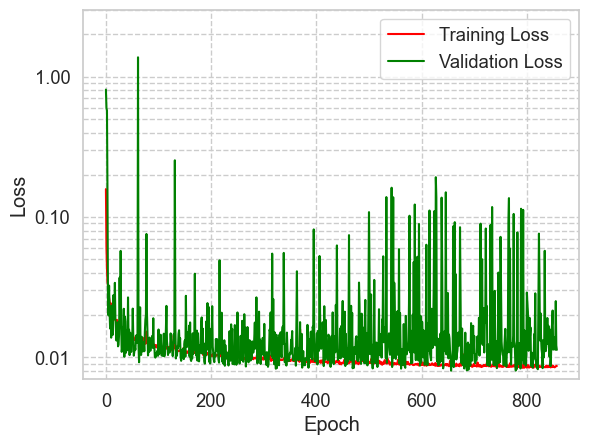

In [24]:
sns.set_theme(font_scale=1.2)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

ax = sns.lineplot(loaded_history['loss'], color='red', label='Training Loss')
sns.lineplot(loaded_history['val_loss'], color='green', label='Validation Loss')

plt.xlabel('Epoch')

plt.ylim(0.007, 3)
plt.yscale('log')
plt.ylabel('Loss')

plt.grid(True, which='minor', linestyle='--', linewidth=1.0)
formatter = ticker.FuncFormatter(lambda x, p: f'{x:,.2f}')
ax.yaxis.set_major_formatter(formatter)

In [25]:
print(len(loaded_history['loss']))
print(np.argmin(loaded_history['val_loss']))

858
656
